In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

# Hard vs. soft membrane voltage reset
Loihi's built-in membrane voltage reset mechanism performs a "hard" reset which always resets the membrane voltage back to zero, regardless of how much the membrane voltage exceeds the spiking threshold. This can lead to inaccuracies for rate codes and so a "soft" reset mechanism is desirable by which the membrane threshold only gets subtracted from the current membrane voltage above threshold. 

To realize a "soft" reset, either a two or three compartment neuron can be constructed using Loihi's multi-compartment features. In this scenario, the synaptic input is integrated via "dendritic" compartments that do not spike and a "somatic" compartment at the root of the dendritic tree that emits regular output spikes but also inhibits its own "dendritic" compartments via an inhibitory connection whereby the inhibitory weight corresponds to the negative membrane threshold.

This workaround allows to realize a "soft" membrane reset, however, at the expense of additional compartment resources per neuro core.

In [2]:
import os
import matplotlib.pyplot as plt
from nxsdk.arch.n2a.n2board import N2Board
from nxsdk.graph.nxinputgen.nxinputgen import BasicSpikeGenerator

## Configuration parameters
These are some shared neuron parameters we use for all three neurons.

In [3]:
tauU = 2
tauV = 25
decayU = int(1/tauU*2**12)
decayV = int(1/tauV*2**12)
vth = 120
inWgt = 35

## Network setup
In the following we are going to set up three neurons on a single core that all receive the same spiking input from a spike generator.
The first is a single compartment (cxId=0) neuron serves as a reference and performs a "hard" membrane potential reset when its membrane potential exceeds the spikiing thresholds. The two- (cxId=1..2) and three-compartment (cxId=3..5) neurons perform a "soft" reset.
### Setup N2Core
This sets up the board with a single chip and core. All neurons use the same threshold. cxMetaState phases need to be initialized as IDLE for the multi-compartment neurons to work.

In [4]:
board = N2Board(id=1, numChips=1, numCores=[1], initNumSynapses=[[10]])
n2Core = board.n2Chips[0].n2Cores[0]

n2Core.numUpdates.configure(numUpdates=2)
n2Core.vthProfileCfg[0].staticCfg.configure(vth=vth)
n2Core.dendriteSharedCfg[0].configure(dsOffset=0,
                                      dmOffsets=0)
n2Core.cxMetaState[0].configure(phase0=2, phase1=2, phase2=2, phase3=2)
n2Core.cxMetaState[1].configure(phase0=2, phase1=2, phase2=2, phase3=2)

### Setup SpikeGenerator that excites single-, two- and three-compartment neurons
Here we setup a spike generator sending spikes to the first input axon (synMapId=0) at t=5, 10, 15, 20, 25.
The input compartments of the three neurons are at cxId 0 (single-comppartment neuron), 1 (two-compartment neuron) and 2 (three-compartment neuron).

In [5]:
# Create input generator
sg = BasicSpikeGenerator(board)
sg.addSpike( 5, 0, 4, 0)
sg.addSpike(10, 0, 4, 0)
sg.addSpike(15, 0, 4, 0)
sg.addSpike(20, 0, 4, 0)
sg.addSpike(25, 0, 4, 0)

# Connect spike generator to input compartments
n2Core.synapseMap[0].synapsePtr = 0
n2Core.synapseMap[0].synapseLen = 3
n2Core.synapseMap[0].discreteMapEntry.cxBase = 0

n2Core.synapses[0].configure(CIdx=0, Wgt=inWgt, synFmtId=1)
n2Core.synapses[1].configure(CIdx=1, Wgt=inWgt, synFmtId=1)
n2Core.synapses[2].configure(CIdx=3, Wgt=inWgt, synFmtId=1)

n2Core.synapseFmt[1].configure(numSynapses=63, 
                               idxBits=1, 
                               fanoutType=1, 
                               compression=0,
                               wgtBits=7)

/home/joyeshmi/nxsdk-nxsdk/nxsdk/graph/nxinputgen/../../snips/


### Setup reference compartment performing regular "hard" reset
The single-compartment neuron is supposed to fire when the membrane potential exceeds the spiking threshold. Thus we set threshOp=0.

In [6]:
n2Core.cxProfileCfg[0].configure(decayU=decayU,
                                 decayV=decayV,
                                 threshOp=0)
n2Core.cxCfg[0].configure(cxProfile=0, vthProfile=0)

### Setup two-compartment neuron performing "soft" reset
The "dendritic" input compartment (cxId=1) uses threshOp=2 which makes it only evaluates the membrane potential but it won't fire when its membrane voltage crosses the membrane potential and thus the membrane potential won't experience a "hard" reset to 0. Instead it pushes the event S = v>vth onto the multi-compartment stack by setting stackOut=1.

The "somatic" output compartment (cxId=2) pops the event S from the multi-compartment stack and since it uses joinOp=6 (OR_S) it will fire immediately when its input compartment crosses threshold. 

The "somatic" compartment can be configured to connect anywhere. Here we only connect it back to the "dendritic" input compartment with a weight proportional to the negative membrane threshold. Since the "dendritic" compartment has a finite decayU constant, we scale down the membrane potential such that the integral weight equals the negative membrane potential:
$$
\int_0^\infty w^{inh}\cdot e^{-\delta^u \cdot t} dt = \frac{w^{inh}}{\delta^u} = -v^{th},~\delta^u=\frac{decayU}{4096}\in{0..1}\\
w^{inh} = -v^{th}\cdot \frac{decayU}{4096}
$$

In [7]:
# Configure two-compartment neuron
n2Core.cxProfileCfg[1].configure(decayU=decayU,
                                 decayV=decayV,
                                 threshOp=2,
                                 stackOut=1)
n2Core.cxProfileCfg[2].configure(decayU=4095,
                                 decayV=4095,
                                 threshOp=0,
                                 stackIn=2,
                                 joinOp=6)
n2Core.cxCfg[1].configure(cxProfile=1, vthProfile=0)
n2Core.cxCfg[2].configure(cxProfile=2, vthProfile=0)

# Connect somatic compartment with dendritic compartment
n2Core.createDiscreteAxon(srcCxId=2, dstChipId=0, dstCoreId=4, dstSynMapId=1)

n2Core.synapseMap[1].synapsePtr = 3
n2Core.synapseMap[1].synapseLen = 1
n2Core.synapseMap[1].discreteMapEntry.cxBase = 0

wgtInh = -int(vth * decayU/4096)
n2Core.synapses[3].configure(CIdx=1, Wgt=wgtInh, synFmtId=1)

### Setup three-compartment neuron performing "soft" reset
The three-compartment neuron operates similarly to the two-compartment neuron except that the former "dendritic" input compartment is separated into two compartments: one which integrates the regular synaptic input which then feeds into another compartment that integrates only the inhibitory spike from the "somatic" compartment without any filtering to avoid the effect of temporal integration of the membrane voltage reset.

The synaptic input compartment (cxId=3) and somatic compartment (cxId=5) are configured just like the compartments of the two-compartment neuron above with the exception that the decayV constant of the "dendritic" input compartment is set to 4095. As a result, the synaptic input current is passed without any further filtering to the middle compartment (cxId=4) which also integrates the reset spike from the "somatic" compartment without further filtering into its membrane potential which then decays with the former decayV constant.

Thus this allows to realize a clean "soft" reset without side effects.

In [8]:
# Configure three-compartment neuron
n2Core.cxProfileCfg[3].configure(decayU=decayU,
                                 decayV=4095,
                                 threshOp=2,
                                 stackOut=1)
n2Core.cxProfileCfg[4].configure(decayU=4095,
                                 decayV=decayV,
                                 threshOp=2,
                                 stackIn=2,
                                 stackOut=1,
                                 joinOp=1)
n2Core.cxProfileCfg[5].configure(decayU=4095,
                                 decayV=0,
                                 threshOp=0,
                                 stackIn=2,
                                 joinOp=6)
n2Core.cxCfg[3].configure(cxProfile=3, vthProfile=0)
n2Core.cxCfg[4].configure(cxProfile=4, vthProfile=0)
n2Core.cxCfg[5].configure(cxProfile=5, vthProfile=0)

# Connect somatic compartment with middle compartment
n2Core.createDiscreteAxon(srcCxId=5, dstChipId=0, dstCoreId=4, dstSynMapId=2)

n2Core.synapseMap[2].synapsePtr = 4
n2Core.synapseMap[2].synapseLen = 1
n2Core.synapseMap[2].discreteMapEntry.cxBase = 0

n2Core.synapses[4].configure(CIdx=4, Wgt=-vth, synFmtId=1)

### Create probes and run
Here we create probes for all u, v and output spikes of all compartments of the individual neurons.

In [9]:
mon = board.monitor
# Single-compartment neuron probes
u0Probe = mon.probe(n2Core.cxState, [0], 'u')
v0Probe = mon.probe(n2Core.cxState, [0], 'v')
s0Probe = mon.probe(n2Core.cxState, [0], 'spike')

# Two-compartment neuron probes
u1Probe = mon.probe(n2Core.cxState, [1], 'u')
v1Probe = mon.probe(n2Core.cxState, [1], 'v')
s1Probe = mon.probe(n2Core.cxState, [1], 'spike')
u2Probe = mon.probe(n2Core.cxState, [2], 'u')
v2Probe = mon.probe(n2Core.cxState, [2], 'v')
s2Probe = mon.probe(n2Core.cxState, [2], 'spike')

# Three-compartment neuron probes
u3Probe = mon.probe(n2Core.cxState, [3], 'u')
v3Probe = mon.probe(n2Core.cxState, [3], 'v')
s3Probe = mon.probe(n2Core.cxState, [3], 'spike')
u4Probe = mon.probe(n2Core.cxState, [4], 'u')
v4Probe = mon.probe(n2Core.cxState, [4], 'v')
s4Probe = mon.probe(n2Core.cxState, [4], 'spike')
u5Probe = mon.probe(n2Core.cxState, [5], 'u')
v5Probe = mon.probe(n2Core.cxState, [5], 'v')
s5Probe = mon.probe(n2Core.cxState, [5], 'spike')

## Run network

In [10]:
board.run(30)
board.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:34733
INFO:DRV:      Host server up..............Done 0.19s
INFO:DRV:      Compiling snips.............Done 0.24s
INFO:DRV:      Encoding axons/synapses.....Done 1.45ms
INFO:DRV:      Encoding probes.............Done 0.14ms
INFO:DRV:      Booting up..................Done 2.59s
INFO:DRV:      Transferring probes.........Done 2.71ms
INFO:DRV:      Configuring registers.......Done 2.95ms
INFO:DRV:      Transferring spikes.........Done 1.29ms
INFO:DRV:      Executing...................Done 3.40ms
INFO:DRV:      Processing timeseries.......Done 5.34ms
INFO:DRV:  Executor: 30 timesteps..........Done 3.05s


## Plot utility
Here we define a function that will plot the u, v and spike probes of a compartment vertically stacked. The global membrane potential is drawn as a horizontal dashed red line.

In [11]:
def plotCxState(uProbe, vProbe, sProbe, id, num):
    ax = plt.subplot(3, num, id)
    uProbe[0].plot()
    plt.title('u'+str(id))
    plt.subplot(3, num, num+id)
    vProbe[0].plot()
    plt.hlines(vth*64, *ax.get_xlim(), linestyle='--', color='r')
    plt.gca().set_xlim(ax.get_xlim())
    plt.title('v'+str(id))
    plt.subplot(3, num, 2*num+id)
    sProbe[0].plot()
    plt.title('s'+str(id))
    plt.gca().set_xlim(ax.get_xlim())

## Results
### Single compartment neuron
The weights and threshold are configured such that the neuron spikes at the third input spike after which the membrane potential performs a "hard" reset.

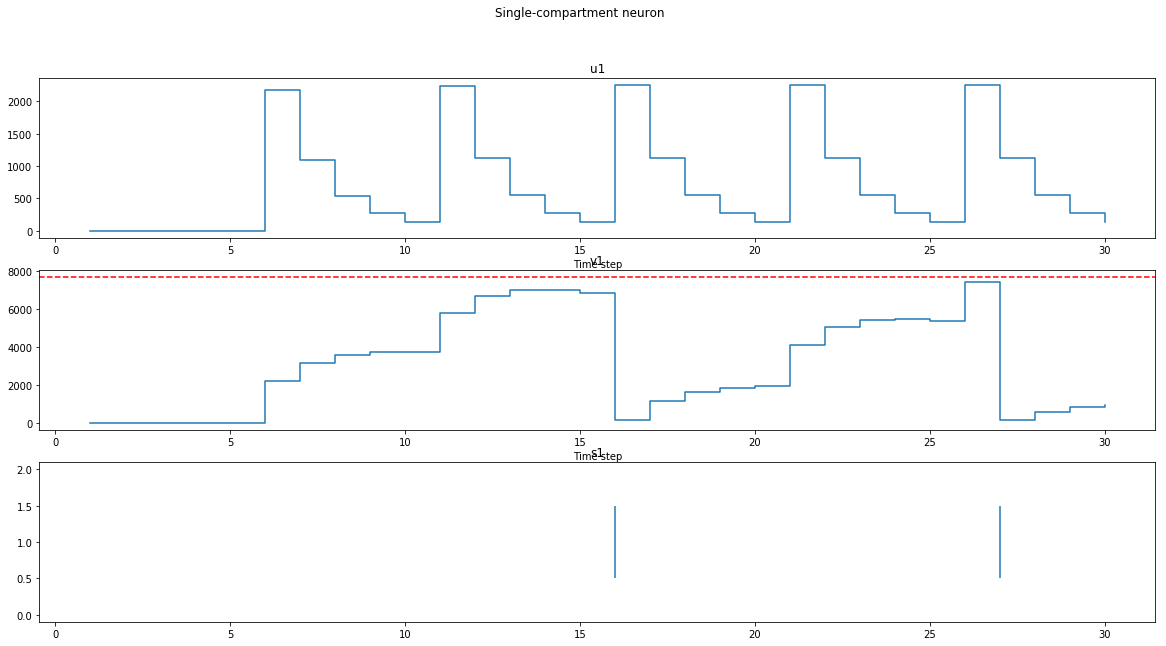

In [12]:
plt.figure(figsize=(20,10))
plt.suptitle('Single-compartment neuron')
plotCxState(u0Probe, v0Probe, s0Probe, 1, 1)

### Two-compartment neuron
Here the membrane potential will also exceed threshold in response to the third input spike but the membrane potential v1 does not reset immediately. However in that same time step, the "somatic" compartment spikes and sends a spike back to the "dendritic" compartment. Thus in the next time step u1 decreases strongly (but not by the full amount of vth) which then gets subtracted from v1 over time.

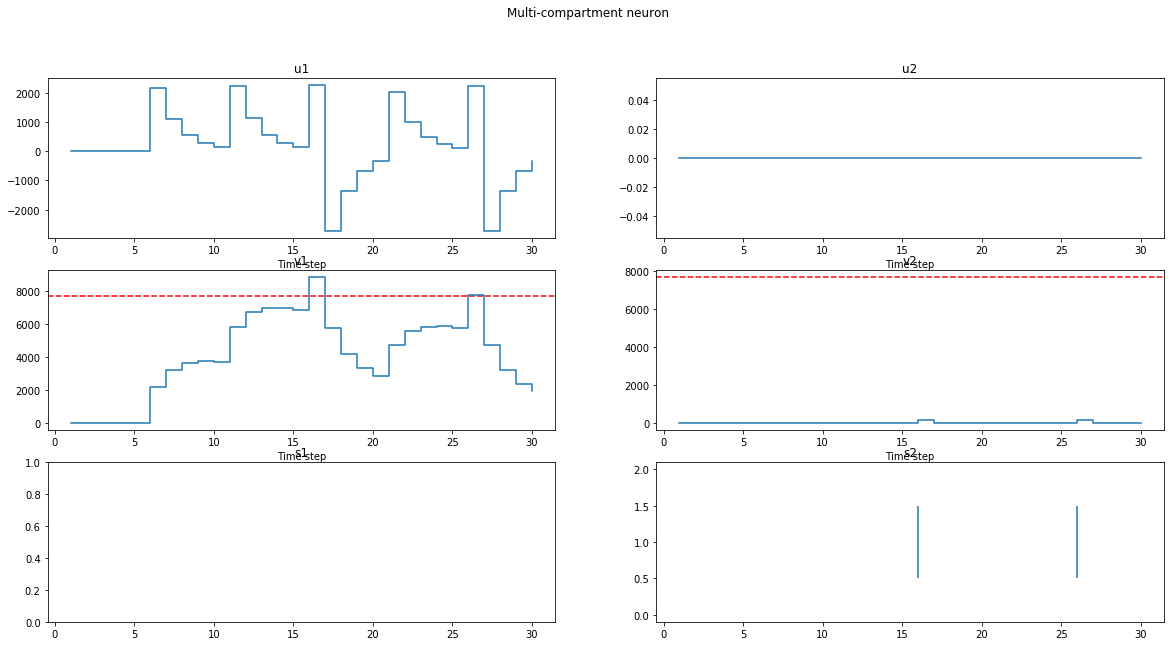

In [13]:
plt.figure(figsize=(20, 10))
plt.suptitle('Multi-compartment neuron')
plotCxState(u1Probe, v1Probe, s1Probe, 1, 2)
plotCxState(u2Probe, v2Probe, s2Probe, 2, 2)

### Three compartment neuron
Here the behavior is similar as for the two-compartment neuron with the exception that upon the spike of the "somatic" compartment the full value of vth gets intgrated into u2 and subtraced from v2 at once. Of course in the time step after the spike, the -vth and the current input from v1 are added by v2 and thus the reset of v2 is slightly less than vth.

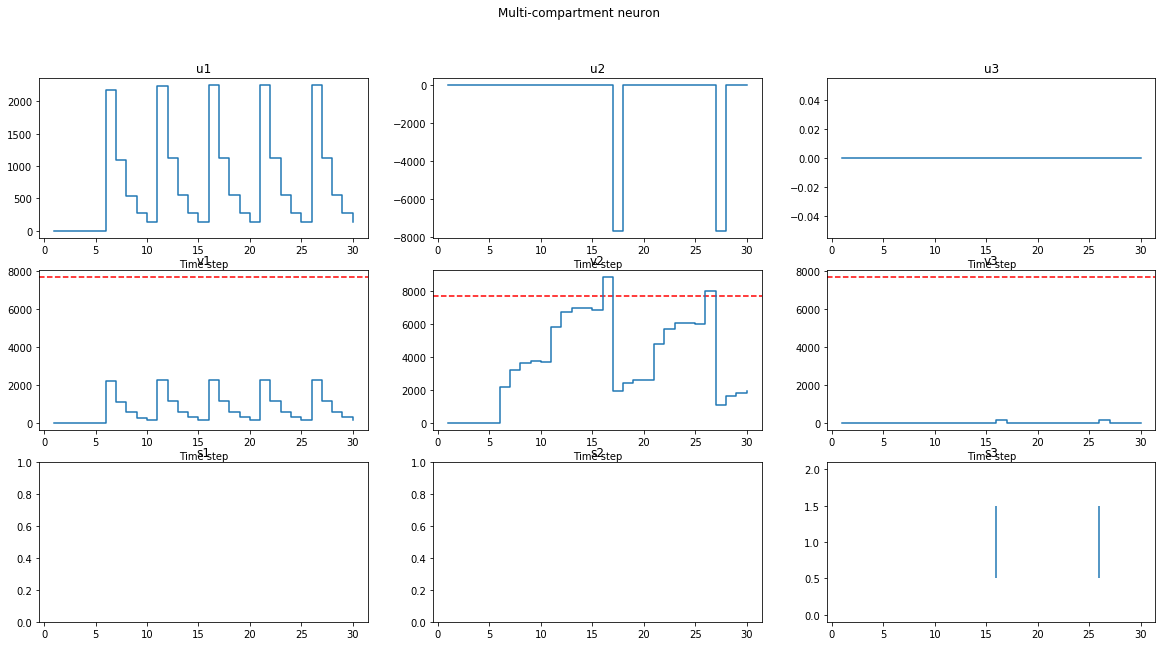

In [14]:
plt.figure(figsize=(20, 10))
plt.suptitle('Multi-compartment neuron')
plotCxState(u3Probe, v3Probe, s3Probe, 1, 3)
plotCxState(u4Probe, v4Probe, s4Probe, 2, 3)
plotCxState(u5Probe, v5Probe, s5Probe, 3, 3)

.. code-links:: python clear